In [1]:
pip install transformers torch datasets tqdm scikit-learn Pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import datetime
from datasets import load_dataset
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score

### Image loading

In [3]:
from datasets import load_from_disk

# Laden des Datasets aus dem Ordner "vision_preprocessed_data"
train_dataset = load_from_disk("vision_preprocessed_data")

Loading dataset from disk:   0%|          | 0/65 [00:00<?, ?it/s]

In [4]:
# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)

### Split data

In [5]:
# Split the dataset into training and validation sets
total_size = len(train_dataset)
train_size = int(0.8 * total_size)   
val_size = int(0.2 * total_size)

In [6]:
total_size

28800

In [7]:
# Generate splits using the seed for reproducibility
generator = torch.Generator().manual_seed(seed)  
train_split, val_split = random_split(train_dataset, [train_size, val_size], generator=generator)

In [8]:
# Verify the sizes of the splits
assert len(train_split) == train_size
assert len(val_split) == val_size

In [9]:
def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(item['pixel_values']) for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return {'pixel_values': pixel_values, 'label': labels}

In [10]:
num_classes = 12  # number of categories
num_epochs =  20 # 20
learning_rate = 0.001 
batch_size = 64

In [11]:
train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True, num_workers=10, collate_fn=collate_fn)
val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False, num_workers=10, collate_fn=collate_fn)

In [12]:
# Create dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader}

In [13]:
# Create dataset_sizes dictionary for calculating losses and accuracies
dataset_sizes = {'train': len(train_split), 'val': len(val_split)}

### Load model

In [14]:
# Load the pre-trained Vision Transformer model and set the number of labels (categories)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                 num_labels=num_classes)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Define loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Loss function suiting classification problems

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  
# Initial learning rate of 0.001
# weight_decay corresponds to the L2 regularization. Prevents overfitting by penalizing large weight values.

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 
# optim = type of learning rate being used
# optimizer = optimizer whose learning rates are being adjusted
# Step size = number of epochs between parameters adjustments
# gamma = The factor by which the learning rate is reduced at each step.

In [16]:
import torch
print("CUDA verfügbar:", torch.cuda.is_available())

CUDA verfügbar: True


In [17]:
# Move the model to a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Training and Validation loop

In [19]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import numpy as np
import time
import torch
from tqdm import tqdm  # Importiere tqdm für Fortschrittsbalken

# Initialize metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_labels = []
val_predictions = []

val_f1_scores = []
val_precisions = []
val_recalls = []
val_conf_matrices = []

# Early stopping parameters
patience = 5
min_improvement = 0.001
early_stopping_counter = 0
best_val_accuracy = 0.0
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_model_path = f'best_model_{current_time}.pth'

# Training and validation loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        all_preds = []
        all_labels = []

        start_time = time.time()  # Startzeit der Epoche

        # Fortschrittsbalken für den jeweiligen Phase (Train oder Validation)
        for batch in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} epoch {epoch+1}/{num_epochs}", unit="batch"):
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs).logits
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Calculate additional metrics
            f1 = f1_score(all_labels, all_preds, average='weighted')
            precision = precision_score(all_labels, all_preds, average='weighted')
            recall = recall_score(all_labels, all_preds, average='weighted')

            val_f1_scores.append(f1)
            val_precisions.append(precision)
            val_recalls.append(recall)

            print(f'Validation F1: {f1:.4f} Precision: {precision:.4f} Recall: {recall:.4f}')

            conf_matrix = confusion_matrix(all_labels, all_preds)
            val_conf_matrices.append(conf_matrix)

            # Check if improvement exceeds the minimum threshold (min_improvement)
            if epoch_acc > best_val_accuracy + min_improvement:
                best_val_accuracy = epoch_acc
                early_stopping_counter = 0
                torch.save(model.state_dict(), best_model_path)
                print(f'Saved best model at epoch {epoch + 1} with validation accuracy: {best_val_accuracy:.4f}')
            else:
                early_stopping_counter += 1

        epoch_time = time.time() - start_time  # Zeit der Epoche berechnen
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time: {epoch_time:.2f}s')

    scheduler.step()

    if early_stopping_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

print('Training complete.')
print(f'Best validation accuracy: {best_val_accuracy:.4f}')


Epoch 1/20
----------


Train epoch 1/20: 100%|██████████| 360/360 [19:41<00:00,  3.28s/batch]


train Loss: 1.7818 Acc: 0.3398 Time: 1181.64s


Val epoch 1/20: 100%|██████████| 90/90 [01:57<00:00,  1.31s/batch]


Validation F1: 0.3185 Precision: 0.3555 Recall: 0.3887
Saved best model at epoch 1 with validation accuracy: 0.3887
val Loss: 1.5831 Acc: 0.3887 Time: 118.09s
Epoch 2/20
----------


Train epoch 2/20: 100%|██████████| 360/360 [19:35<00:00,  3.27s/batch]


train Loss: 1.5206 Acc: 0.4140 Time: 1175.89s


Val epoch 2/20: 100%|██████████| 90/90 [01:57<00:00,  1.30s/batch]


Validation F1: 0.4282 Precision: 0.4636 Recall: 0.4564
Saved best model at epoch 2 with validation accuracy: 0.4564
val Loss: 1.4305 Acc: 0.4564 Time: 117.71s
Epoch 3/20
----------


Train epoch 3/20: 100%|██████████| 360/360 [19:44<00:00,  3.29s/batch]


train Loss: 1.4194 Acc: 0.4524 Time: 1184.77s


Val epoch 3/20: 100%|██████████| 90/90 [01:56<00:00,  1.29s/batch]


Validation F1: 0.3979 Precision: 0.4917 Recall: 0.4349
val Loss: 1.4115 Acc: 0.4349 Time: 116.39s
Epoch 4/20
----------


Train epoch 4/20: 100%|██████████| 360/360 [19:44<00:00,  3.29s/batch]


train Loss: 1.3298 Acc: 0.4893 Time: 1184.76s


Val epoch 4/20: 100%|██████████| 90/90 [01:56<00:00,  1.30s/batch]


Validation F1: 0.4462 Precision: 0.5109 Recall: 0.4944
Saved best model at epoch 4 with validation accuracy: 0.4944
val Loss: 1.3384 Acc: 0.4944 Time: 117.29s
Epoch 5/20
----------


Train epoch 5/20: 100%|██████████| 360/360 [19:39<00:00,  3.28s/batch]


train Loss: 1.2701 Acc: 0.5186 Time: 1179.61s


Val epoch 5/20: 100%|██████████| 90/90 [01:56<00:00,  1.30s/batch]


Validation F1: 0.4798 Precision: 0.5085 Recall: 0.5062
Saved best model at epoch 5 with validation accuracy: 0.5062
val Loss: 1.3174 Acc: 0.5062 Time: 117.23s
Epoch 6/20
----------


Train epoch 6/20: 100%|██████████| 360/360 [19:39<00:00,  3.28s/batch]


train Loss: 1.0747 Acc: 0.5949 Time: 1179.69s


Val epoch 6/20: 100%|██████████| 90/90 [01:58<00:00,  1.31s/batch]


Validation F1: 0.5774 Precision: 0.5916 Recall: 0.5823
Saved best model at epoch 6 with validation accuracy: 0.5823
val Loss: 1.0836 Acc: 0.5823 Time: 118.62s
Epoch 7/20
----------


Train epoch 7/20: 100%|██████████| 360/360 [19:39<00:00,  3.28s/batch]


train Loss: 0.9672 Acc: 0.6408 Time: 1179.90s


Val epoch 7/20: 100%|██████████| 90/90 [01:59<00:00,  1.33s/batch]


Validation F1: 0.6154 Precision: 0.6184 Recall: 0.6233
Saved best model at epoch 7 with validation accuracy: 0.6233
val Loss: 1.0189 Acc: 0.6233 Time: 119.82s
Epoch 8/20
----------


Train epoch 8/20: 100%|██████████| 360/360 [19:38<00:00,  3.27s/batch]


train Loss: 0.8820 Acc: 0.6747 Time: 1178.51s


Val epoch 8/20: 100%|██████████| 90/90 [01:58<00:00,  1.32s/batch]


Validation F1: 0.6227 Precision: 0.6372 Recall: 0.6250
Saved best model at epoch 8 with validation accuracy: 0.6250
val Loss: 1.0148 Acc: 0.6250 Time: 119.16s
Epoch 9/20
----------


Train epoch 9/20: 100%|██████████| 360/360 [19:40<00:00,  3.28s/batch]


train Loss: 0.8037 Acc: 0.7082 Time: 1180.08s


Val epoch 9/20: 100%|██████████| 90/90 [01:59<00:00,  1.32s/batch]


Validation F1: 0.6526 Precision: 0.6665 Recall: 0.6601
Saved best model at epoch 9 with validation accuracy: 0.6601
val Loss: 0.9458 Acc: 0.6601 Time: 119.53s
Epoch 10/20
----------


Train epoch 10/20: 100%|██████████| 360/360 [19:38<00:00,  3.27s/batch]


train Loss: 0.7263 Acc: 0.7354 Time: 1178.76s


Val epoch 10/20: 100%|██████████| 90/90 [01:57<00:00,  1.31s/batch]


Validation F1: 0.6564 Precision: 0.6719 Recall: 0.6578
val Loss: 0.9585 Acc: 0.6578 Time: 117.81s
Epoch 11/20
----------


Train epoch 11/20: 100%|██████████| 360/360 [19:39<00:00,  3.28s/batch]


train Loss: 0.6024 Acc: 0.7890 Time: 1179.96s


Val epoch 11/20: 100%|██████████| 90/90 [01:56<00:00,  1.30s/batch]


Validation F1: 0.6775 Precision: 0.6804 Recall: 0.6788
Saved best model at epoch 11 with validation accuracy: 0.6788
val Loss: 0.9307 Acc: 0.6788 Time: 117.30s
Epoch 12/20
----------


Train epoch 12/20: 100%|██████████| 360/360 [19:40<00:00,  3.28s/batch]


train Loss: 0.5663 Acc: 0.8037 Time: 1180.11s


Val epoch 12/20: 100%|██████████| 90/90 [01:56<00:00,  1.29s/batch]


Validation F1: 0.6782 Precision: 0.6812 Recall: 0.6800
Saved best model at epoch 12 with validation accuracy: 0.6800
val Loss: 0.9363 Acc: 0.6800 Time: 116.59s
Epoch 13/20
----------


Train epoch 13/20: 100%|██████████| 360/360 [19:38<00:00,  3.27s/batch]


train Loss: 0.5454 Acc: 0.8105 Time: 1178.23s


Val epoch 13/20: 100%|██████████| 90/90 [01:56<00:00,  1.29s/batch]


Validation F1: 0.6780 Precision: 0.6811 Recall: 0.6807
val Loss: 0.9450 Acc: 0.6807 Time: 116.37s
Epoch 14/20
----------


Train epoch 14/20: 100%|██████████| 360/360 [19:39<00:00,  3.28s/batch]


train Loss: 0.5275 Acc: 0.8172 Time: 1179.85s


Val epoch 14/20: 100%|██████████| 90/90 [01:56<00:00,  1.29s/batch]


Validation F1: 0.6786 Precision: 0.6835 Recall: 0.6793
val Loss: 0.9573 Acc: 0.6793 Time: 116.18s
Epoch 15/20
----------


Train epoch 15/20: 100%|██████████| 360/360 [19:38<00:00,  3.27s/batch]


train Loss: 0.5115 Acc: 0.8227 Time: 1178.75s


Val epoch 15/20: 100%|██████████| 90/90 [01:57<00:00,  1.30s/batch]


Validation F1: 0.6763 Precision: 0.6794 Recall: 0.6769
val Loss: 0.9669 Acc: 0.6769 Time: 117.14s
Epoch 16/20
----------


Train epoch 16/20: 100%|██████████| 360/360 [19:38<00:00,  3.27s/batch]


train Loss: 0.4902 Acc: 0.8340 Time: 1178.69s


Val epoch 16/20: 100%|██████████| 90/90 [01:57<00:00,  1.30s/batch]


Validation F1: 0.6782 Precision: 0.6807 Recall: 0.6795
val Loss: 0.9644 Acc: 0.6795 Time: 117.24s
Epoch 17/20
----------


Train epoch 17/20: 100%|██████████| 360/360 [19:38<00:00,  3.27s/batch]


train Loss: 0.4870 Acc: 0.8349 Time: 1178.82s


Val epoch 17/20: 100%|██████████| 90/90 [01:56<00:00,  1.30s/batch]

Validation F1: 0.6772 Precision: 0.6796 Recall: 0.6786
val Loss: 0.9651 Acc: 0.6786 Time: 116.85s
Early stopping triggered after 17 epochs.
Training complete.
Best validation accuracy: 0.6800


### Save values

In [21]:
import pandas as pd
# Create a dictionary for data
data = {
    "epoch": range(1, len(train_losses) + 1),  # Epochs start from 1
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
    "val_f1_score": val_f1_scores,
    "val_precision": val_precisions,
    "val_recall": val_recalls,
    "val_conf_matrix": val_conf_matrices,  # You may want to adjust how to store this, depending on the format you prefer
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Save to a CSV file
file_name = f"training_results_{current_time}.csv"
df.to_csv(file_name, index=False)


### Visualization of training results

In [22]:
len(train_losses)

17

Best validation accuracy: 0.6807 (Epoch 13)
Final accuracy gap (train - val): 0.1563


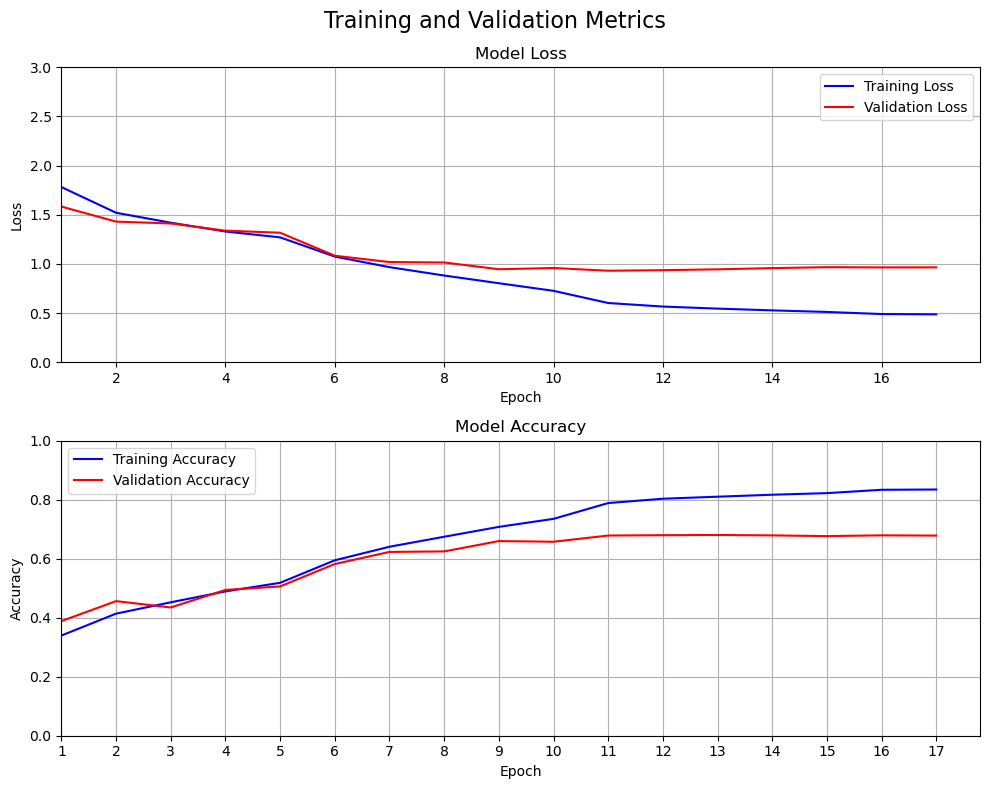

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure that the number of epochs corresponds to the length of the loss/accuracy lists
num_epochs = len(train_losses)

# Calculate best validation accuracy and best epoch
best_val_accuracy = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_accuracy) + 1  # +1 to match epoch number (1-based index)

# Define stopped_epoch for early stopping
stopped_epoch = best_epoch + patience if early_stopping_counter < patience else num_epochs

# Data from your training output
epochs = range(1, num_epochs + 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training & validation loss values
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 3)
ax1.set_xlim(1)
ax1.legend()
ax1.grid()

# Plot training & validation accuracy values
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.set_xlim(1)
ax2.set_xticks(ticks=np.arange(1, num_epochs + 1, 1))  # Adjust ticks based on num_epochs
ax2.legend()
ax2.grid()

# Adjust layout and display the plot
fig.tight_layout()
ax1.plot()
ax2.plot()
fig.show()

# Print best validation accuracy and final accuracy gap
print(f"Best validation accuracy: {best_val_accuracy:.4f} (Epoch {best_epoch})")

# Calculate and print final training-validation gap
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
acc_gap = final_train_acc - final_val_acc
print(f"Final accuracy gap (train - val): {acc_gap:.4f}")


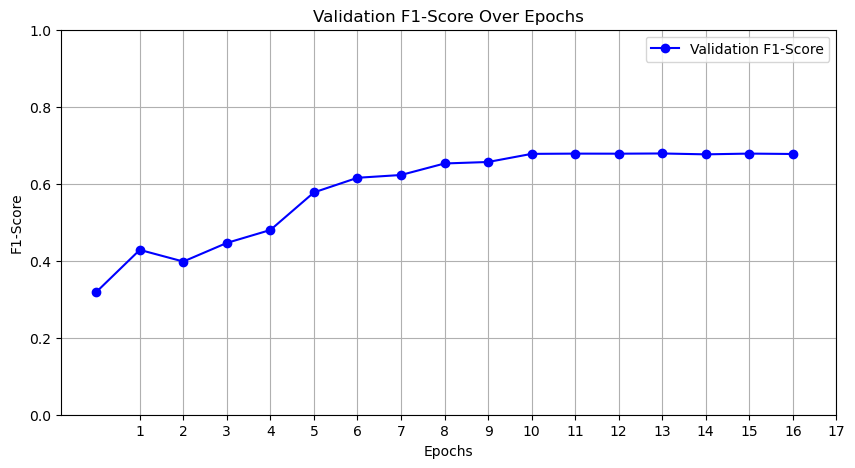

In [26]:
# Plot F1-Score
f, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax.plot(val_f1_scores, label='Validation F1-Score', marker='o', color='blue')
ax.set_xlabel('Epochs', loc='center')
ax.set_ylabel('F1-Score')
ax.set_title('Validation F1-Score Over Epochs')
ax.set_ylim(0, 1)
ax.set_xticks(ticks=np.arange(1, stopped_epoch + 1, 1))
ax.legend()
ax.grid()
f.show()

13


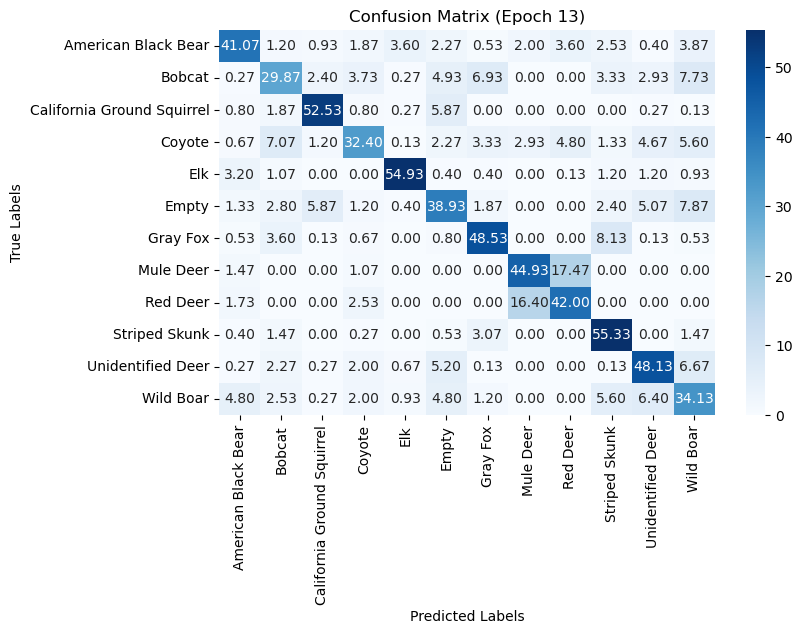

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

print(best_epoch)

# Confusion Matrix for the Best Epoch
conf_matrix = val_conf_matrices[best_epoch - 1]  # Index corresponds to the best epoch

# Alphabetically sorted class names
class_names = ['American Black Bear', 'California Ground Squirrel', 'Elk', 'Gray Fox', 'Red Deer', 'Unidentified Deer', 'Bobcat', 'Coyote', 'Empty', 'Mule Deer', 'Striped Skunk', 'Wild Boar']
class_names.sort()  # Sorting class names alphabetically

# Plot confusion matrix
f, ax = plt.subplots(figsize=(8, 5), sharex=True)
sns.heatmap(conf_matrix / (len(val_loader) / num_classes), annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title(f'Confusion Matrix (Epoch {best_epoch})')
f.show()
